# Bibliotecas

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# Variáveis globais

In [22]:
global goalPos
global gamma, k, h
global Kv, Kw
global tau, kappa

# Modelos cinemáticos

## Funções auxiliares

In [23]:
def calculoVariaveis_Aicardi(state):
    global gamma, k, h
    x, y, phi = state

    xg, yg = goalPos

    #Erro de posição
    e = np.sqrt((xg - x) ** 2 + (yg - y) ** 2)

    theta = np.arctan2(yg - y, xg - x)

    #Erro de orientação
    alpha = theta - phi
    alpha = np.arctan2(np.sin(alpha), np.cos(alpha))  # Normalize angle to [-pi, pi]

    #Leis de controle
    v = gamma*e*np.cos(alpha)
    omega = k*alpha + (gamma/alpha)*(np.sin(alpha)*np.cos(alpha))*(alpha + h*theta)

    return x, y, phi, e, alpha, v, omega


def calculoVariaveis_Karim(state):
    global Kv, Kw

    x, y, theta = state

    Dd = 0 # Desired distance to the goal

    xg, yg = goalPos

    #Erro de posição
    D = np.sqrt((xg - x) ** 2 + (yg - y) ** 2)
    eD = Dd-D

    phi = np.arctan2(yg - y, xg - x)

    #Erro de orientação
    alpha = theta - phi
    alpha = np.arctan2(np.sin(alpha), np.cos(alpha))  # Normalize angle to [-pi, pi]

    #Leis de controle
    v = -Kv*eD*np.cos(alpha)
    omega = -Kw*alpha - (v/D)*np.sin(alpha)

    return x, y, theta, eD, alpha, v, omega


def calculoVariaveis_Breno(state):
    global tau, kappa

    x, y, phi = state
    xg, yg = goalPos

    #Erro de posição
    e = np.sqrt((xg - x) ** 2 + (yg - y) ** 2)

    theta = np.arctan2(yg - y, xg - x)

    #Erro de orientação
    alpha = theta - phi
    alpha = np.arctan2(np.sin(alpha), np.cos(alpha))  # Normalize angle to [-pi, pi]

    #Leis de controle
    v = tau*e*np.cos(alpha)
    omega = kappa*alpha + tau*np.sin(alpha)*np.cos(alpha)

    return x, y, phi, e, alpha, v, omega

## Modelo do Aicardi

In [24]:
def cinematicModel_Aicardi(t, state):
    x, y, phi, e, alpha, v, omega = calculoVariaveis_Aicardi(state)

    #Avanço temporal do modelo
    dx = v * np.cos(phi)
    dy = v * np.sin(phi)
    dphi = omega

    return [dx, dy, dphi]

## Modelo da Karim

In [25]:
def cinematicModel_Karim(t, state):
    x, y, theta, eD, alpha, v, omega = calculoVariaveis_Karim(state)

    #Avanço temporal do modelo
    dx = v * np.cos(theta)
    dy = v * np.sin(theta)
    dtheta = omega

    return [dx, dy, dtheta]

## Modelo de Breno

In [26]:
def cinematicModel_Breno(t, state):
    x, y, phi, e, alpha, v, omega = calculoVariaveis_Breno(state)

    #Avanço temporal do modelo
    dx = v * np.cos(phi)
    dy = v * np.sin(phi)
    dphi = omega

    return [dx, dy, dphi]

## Evento de parada da simulação

In [27]:
def stopEvent(t, state):
    x, y, theta = state
    xg, yg = goalPos
    return np.sqrt((xg - x) ** 2 + (yg - y) ** 2) - 0.01

stopEvent.terminal = True
stopEvent.direction = -1

# Simulação

## Parâmetros padrão da simulação

In [28]:
t_span = (0, 50)  # Time span for the simulation
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points to evaluate

x0 = [0, 0, np.pi/2]  # Initial state: [x, y, phi]
goalPos = [1, 0]

gamma = 0.1
k = 1
h = 1

Kv = 0.1
Kw = 1

tau = 0.1
kappa = 1

## Simulação Aicardi

In [29]:
solution_a = solve_ivp(cinematicModel_Aicardi, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
x_a, y_a, phi_a, e_a, alpha_a, v_a, omega_a = calculoVariaveis_Aicardi(solution_a.y)

## Simulação Karim

In [30]:
solution_k = solve_ivp(cinematicModel_Karim, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
x_k, y_k, theta_k, eD_k, alpha_k, v_k, omega_k = calculoVariaveis_Karim(solution_k.y)

## Simulação Breno

In [31]:
solution_b = solve_ivp(cinematicModel_Breno, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
x_b, y_b, phi_b, e_b, alpha_b, v_b, omega_b = calculoVariaveis_Breno(solution_b.y)

## Plots

(np.float64(0.06815826038864987), np.float64(0.08752353517007777))

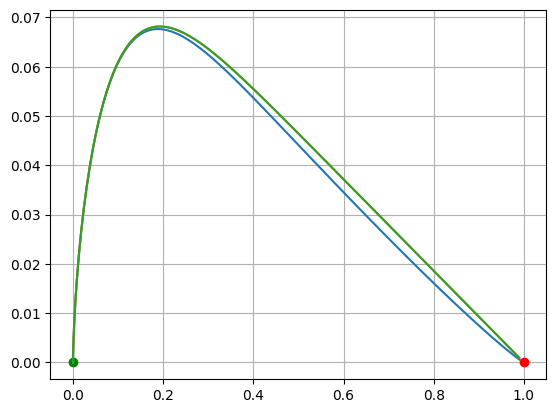

In [32]:
plt.plot(goalPos[0], goalPos[1], 'ro')  # Plot goal position
plt.plot(x_a[0], y_a[0], 'go')  # Plot goal position
plt.plot(x_a, y_a)
plt.plot(x_k, y_k)
plt.plot(x_b, y_b)
#plt.xlim(-2.5, 2.5)
#plt.ylim(-2.5, 2.5)
plt.grid()

np.max(y_b), np.max(v_b)

# Ortimização dos parâmetros

## Referencias

In [33]:
from SGA import *

# Função para converter binário -> valor real
def bin_to_real(pop_bin, x_min=0, x_max=4):
    """Converte população binária em valores reais de x"""

    num_bits = len(pop_bin)
    resolucao = (x_max - x_min) / (2**num_bits - 1)

    valores_decimais = pop_bin.dot(2 ** np.arange(num_bits)[::-1])
    return x_min + valores_decimais * resolucao

## Breno

### Speed GA

gen = 000   avgFitness = 107.082  maxFitness = 12006.216
gen = 001   avgFitness = 957.957  maxFitness = 141482.178
gen = 002   avgFitness = 1494.863  maxFitness = 141482.178
gen = 003   avgFitness = 4047.119  maxFitness = 205358.332
gen = 004   avgFitness = 1150.113  maxFitness = 100349.500
gen = 005   avgFitness = 1623.085  maxFitness = 133333.518
gen = 006   avgFitness = 3796.115  maxFitness = 247734.686
gen = 007   avgFitness = 5805.455  maxFitness = 253414.869
gen = 008   avgFitness = 7696.248  maxFitness = 251437.844
gen = 009   avgFitness = 11709.686  maxFitness = 267450.521
gen = 010   avgFitness = 21531.591  maxFitness = 314084.487
gen = 011   avgFitness = 40934.123  maxFitness = 783107.047
gen = 012   avgFitness = 59279.825  maxFitness = 783107.047
gen = 013   avgFitness = 121864.607  maxFitness = 5616711.597
gen = 014   avgFitness = 146023.585  maxFitness = 11421311.214
gen = 015   avgFitness = 270919.918  maxFitness = 11421311.214
gen = 016   avgFitness = 540946.728  maxFitn

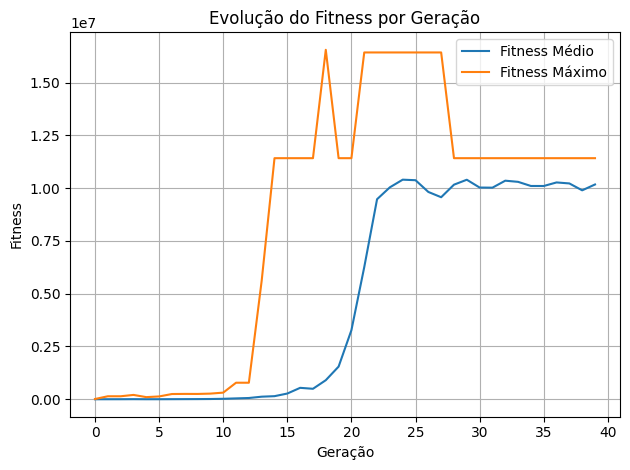

Melhor tau: 1.0024
Melhor kappa: 3.6748

Max(y) = 0.1400
Max(u) = 0.7820
Max(w) = 330.7286°/s


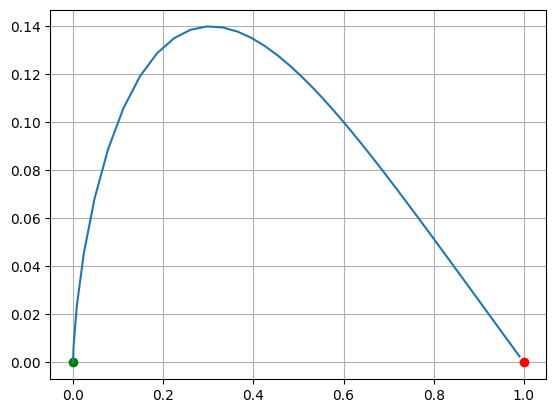

In [34]:
x0 = [0, 0, np.pi/2]  # Reset initial state for Karim's model
goalPos = [1, 0]  # Reset goal position for Karim's model

y_ref = 0.14
v_ref = 1.15

def fitness_function_b(pop):
    global tau, kappa

    fitness_value = []
    for ind in pop:
        tau = bin_to_real(ind[:int(0.5*len(ind))], 0, 4)
        kappa = bin_to_real(ind[int(0.5*len(ind)):], 0, 4)

        sol = solve_ivp(cinematicModel_Breno, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
        x_b, y_b, phi_b, e_b, alpha_b, v_b, omega_b = calculoVariaveis_Breno(sol.y)

        y_max = np.max(y_b)
        u_max = np.max(v_b)

        Phi_y = np.abs(y_max - y_ref)
        Phi_u = np.abs(u_max - v_ref)

        fitness_value.append(1/Phi_y + 1/Phi_u)

    return fitness_value

best = evolve(
    fitnessFunction=fitness_function_b,
    length=40,
    popSize=200,
    maxGens=40,
    probMutation=0.003,
    probCrossover=1
)

half = int(0.5 * len(best))
tau_best   = bin_to_real(best[:half], 0, 4)
kappa_best = bin_to_real(best[half:], 0, 4)

print(f"Melhor tau: {tau_best:.4f}")
print(f"Melhor kappa: {kappa_best:.4f}")

global tau, kappa
tau = tau_best
kappa = kappa_best

solution_b = solve_ivp(cinematicModel_Breno, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
x_b, y_b, phi_b, e_b, alpha_b, v_b, w_b = calculoVariaveis_Breno(solution_b.y)

print()
print(f'Max(y) = {np.max(y_b):.4f}')
print(f'Max(u) = {np.max(v_b):.4f}')
print(f'Max(w) = {np.max(np.abs(w_b*180/np.pi)):.4f}°/s')

plt.plot(goalPos[0], goalPos[1], 'ro')  # Plot goal position
plt.plot(x_a[0], y_a[0], 'go')  # Plot goal position
plt.plot(x_b, y_b)
plt.grid()

### fmincon

Inequality constraints incompatible    (Exit mode 4)
            Current function value: -125175.09033973604
            Iterations: 12
            Function evaluations: 65
            Gradient evaluations: 10
Melhor tau: 1.0807
Melhor kappa: 3.9559

Max(y) = 0.1400
Max(v) = 0.8426
Max(w) = 356.0274°/s


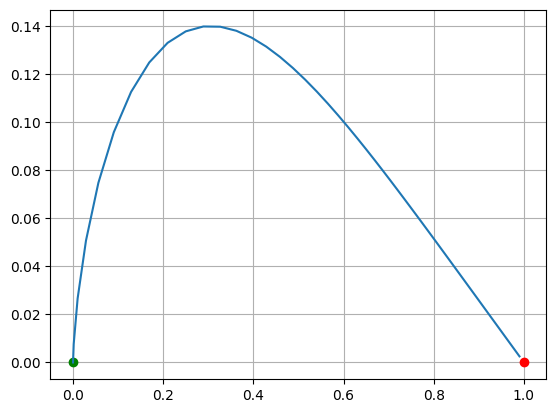

In [35]:
x0 = [0, 0, np.pi/2]  # Reset initial state 
goalPos = [1, 0]  # Reset goal position

y_ref = 0.14
v_ref = 1.1

def cost_function_b(params):
    global tau, kappa

    tau, kappa = params

    sol_b = solve_ivp(cinematicModel_Breno, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
    x_b, y_b, phi_b, e_b, alpha_b, v_b, omega_b = calculoVariaveis_Breno(sol_b.y)

    y_max = np.max(y_b)
    v_max = np.max(v_b)

    Phi_y = np.abs(y_max - y_ref)
    Phi_v = np.abs(v_max - v_ref)

    F = 1/Phi_y + 1/Phi_v

    return -F

controlVar_guess_b = [0.1, 1]  # Initial guess for tau and kappa
bounds = [(0, 4), (0, 4)]  # Bounds for tau and kappa

result = minimize(cost_function_b, controlVar_guess_b, method='SLSQP', bounds=bounds, options={'maxiter': 1000, 'disp': True})

tau_best, kappa_best = result.x

print(f"Melhor tau: {tau_best:.4f}")
print(f"Melhor kappa: {kappa_best:.4f}")

global tau, kappa
tau, kappa = tau_best, kappa_best

sol_b = solve_ivp(cinematicModel_Breno, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
x_b, y_b, phi_b, e_b, alpha_b, v_b, w_b = calculoVariaveis_Breno(sol_b.y)

print()
print(f'Max(y) = {np.max(y_b):.4f}')
print(f'Max(v) = {np.max(v_b):.4f}')
print(f'Max(w) = {np.max(np.abs(w_b*180/np.pi)):.4f}°/s')

plt.plot(goalPos[0], goalPos[1], 'ro')  # Plot goal position
plt.plot(x_b[0], y_b[0], 'go')  # Plot goal
plt.plot(x_b, y_b)
plt.grid()


## Karim

### SpeedGA

gen = 000   avgFitness = 17.804  maxFitness = 651.552
gen = 001   avgFitness = 14.743  maxFitness = 379.674
gen = 002   avgFitness = 22.524  maxFitness = 379.674
gen = 003   avgFitness = 42.793  maxFitness = 999.926
gen = 004   avgFitness = 60.817  maxFitness = 1526.939
gen = 005   avgFitness = 45.556  maxFitness = 1776.167
gen = 006   avgFitness = 26.320  maxFitness = 277.384
gen = 007   avgFitness = 42.916  maxFitness = 1123.078
gen = 008   avgFitness = 43.190  maxFitness = 1658.459
gen = 009   avgFitness = 49.721  maxFitness = 1648.187
gen = 010   avgFitness = 28.824  maxFitness = 649.812
gen = 011   avgFitness = 51.806  maxFitness = 954.706
gen = 012   avgFitness = 145.351  maxFitness = 5197.714
gen = 013   avgFitness = 1650.480  maxFitness = 156690.548
gen = 014   avgFitness = 1692.590  maxFitness = 156690.548
gen = 015   avgFitness = 88.456  maxFitness = 3866.189
gen = 016   avgFitness = 616.814  maxFitness = 54467.384
gen = 017   avgFitness = 1095.589  maxFitness = 54467.384
gen

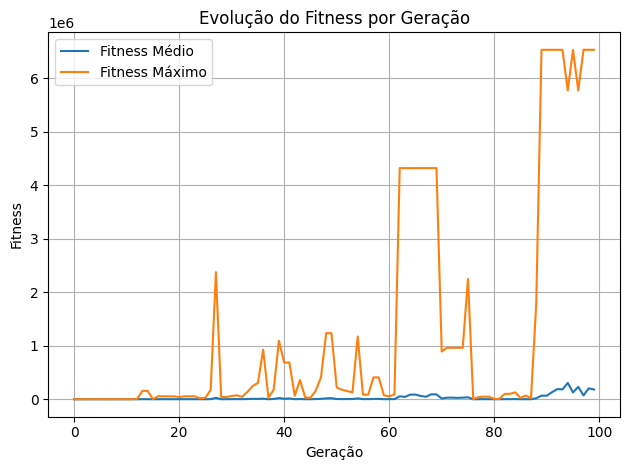

Melhor Kv: 1.6039
Melhor Kw: 2.6726

Max(v) = 1.1000 m/s
Max(w) = 240.5332 °/s


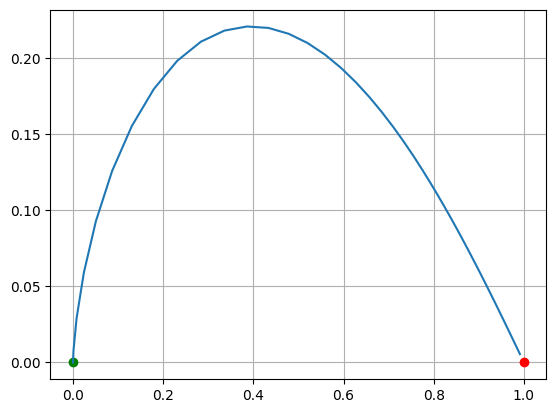

In [36]:
x0 = [0, 0, np.pi/2]  # Reset initial state for Karim's model
goalPos = [1, 0]  # Reset goal position for Karim's model

v_ref = 1.1
w_ref = 300 * np.pi / 180  # Convert to rad/s

# Função de fitness
def fitness_function_k(pop):
    global Kv, Kw

    fitness_values = []

    for ind in pop:
        Kv  = bin_to_real(ind[:int(0.5*len(ind))], 0, 4)
        Kw  = bin_to_real(ind[int(0.5*len(ind)):], 0, 4)

        sol_k = solve_ivp(cinematicModel_Karim, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
        x_k, y_k, theta_k, eD_k, alpha_k, v_k, w_k = calculoVariaveis_Karim(sol_k.y)

        J = 0.5*np.trapezoid((eD_k/eD_k[0])**2 + (alpha_k/alpha_k[0])**2, sol_k.t)
        F = 1/(np.abs(np.max(v_k) - v_ref)) + 1/(np.abs(np.max(np.abs(w_k)) - w_ref))

        fitness_values.append(1/J + F)

    return fitness_values


best = evolve(
    fitnessFunction=fitness_function_k,
    length=40,
    popSize=100,
    maxGens=100,
    probMutation=0.03,
    probCrossover=1
)

half = int(0.5 * len(best))
Kv_best   = bin_to_real(best[:half], 0, 4)
Kw_best = bin_to_real(best[half:], 0, 4)

print(f"Melhor Kv: {Kv_best:.4f}")
print(f"Melhor Kw: {Kw_best:.4f}")

Kv = Kv_best
Kw = Kw_best

sol_k = solve_ivp(cinematicModel_Karim, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
x_k, y_k, theta_k, eD_k, alpha_k, v_k, omega_k = calculoVariaveis_Karim(sol_k.y)

print()
print(f'Max(v) = {np.max(v_k):.4f} m/s')
print(f'Max(w) = {np.max(np.abs(omega_k*180/np.pi)):.4f} °/s')

plt.plot(goalPos[0], goalPos[1], 'ro')  # Plot goal position
plt.plot(x_k[0], y_k[0], 'go')  # Plot goal position
plt.plot(x_k, y_k)
plt.grid()


### fmincon

Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3598246.806476152
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9
Melhor Kv: 1.9829
Melhor Kw: 1.2037

Max(v) = 1.1000 m/s
Max(w) = 121.7738 °/s


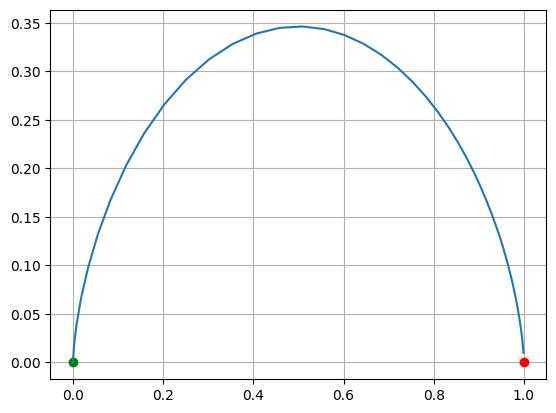

In [37]:
x0 = [0, 0, np.pi/2]  # Reset initial state for Karim's model
goalPos = [1, 0]  # Reset goal position for Karim's model

v_ref = 1.1
w_ref = 300 * np.pi / 180  # Convert to rad/s

def cost_function_k(params):
    global Kv, Kw

    Kv, Kw = params

    sol_k = solve_ivp(cinematicModel_Karim, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
    x_k, y_k, theta_k, eD_k, alpha_k, v_k, omega_k = calculoVariaveis_Karim(sol_k.y)

    J = 0.5*np.trapezoid((eD_k/eD_k[0])**2 + (alpha_k/alpha_k[0])**2, sol_k.t)
    F = 1/(np.abs(np.max(v_k) - v_ref)) + 1/(np.abs(np.max(np.abs(omega_k)) - w_ref))

    return J - F

controlVar_guess_k = [0.1, 1]  # Initial guess for Kv and Kw
bounds = [(0, 4), (0, 4)]  # Bounds for Kv

result = minimize(cost_function_k, controlVar_guess_k, method='SLSQP', bounds=bounds, options={'maxiter': 1000, 'disp': True})

Kv_best, Kw_best = result.x

print(f"Melhor Kv: {Kv_best:.4f}")
print(f"Melhor Kw: {Kw_best:.4f}")

global Kv, Kw
Kv, Kw = Kv_best, Kw_best

sol_k = solve_ivp(cinematicModel_Karim, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
x_k, y_k, theta_k, eD_k, alpha_k, v_k, omega_k = calculoVariaveis_Karim(sol_k.y)

print()
print(f'Max(v) = {np.max(v_k):.4f} m/s')
print(f'Max(w) = {np.max(np.abs(omega_k*180/np.pi)):.4f} °/s')

plt.plot(goalPos[0], goalPos[1], 'ro')  # Plot goal position
plt.plot(x_k[0], y_k[0], 'go')  # Plot goal
plt.plot(x_k, y_k)
plt.grid()

## Aicardi

### SpeedyGA

gen = 000   avgFitness = 139.923  maxFitness = 26394.504
gen = 001   avgFitness = 54.557  maxFitness = 8538.582
gen = 002   avgFitness = 19.516  maxFitness = 681.339
gen = 003   avgFitness = 55.780  maxFitness = 7923.176
gen = 004   avgFitness = 20.901  maxFitness = 1822.304
gen = 005   avgFitness = 16.237  maxFitness = 512.098
gen = 006   avgFitness = 18.970  maxFitness = 511.992
gen = 007   avgFitness = 21.286  maxFitness = 650.666
gen = 008   avgFitness = 33.342  maxFitness = 1714.711
gen = 009   avgFitness = 20.544  maxFitness = 296.131
gen = 010   avgFitness = 38.925  maxFitness = 2795.647
gen = 011   avgFitness = 25.756  maxFitness = 1375.698
gen = 012   avgFitness = 51.974  maxFitness = 4358.565
gen = 013   avgFitness = 34.706  maxFitness = 1417.573
gen = 014   avgFitness = 115.761  maxFitness = 11465.404
gen = 015   avgFitness = 86.081  maxFitness = 11480.555
gen = 016   avgFitness = 21.242  maxFitness = 702.779
gen = 017   avgFitness = 53.697  maxFitness = 1521.870
gen = 018  

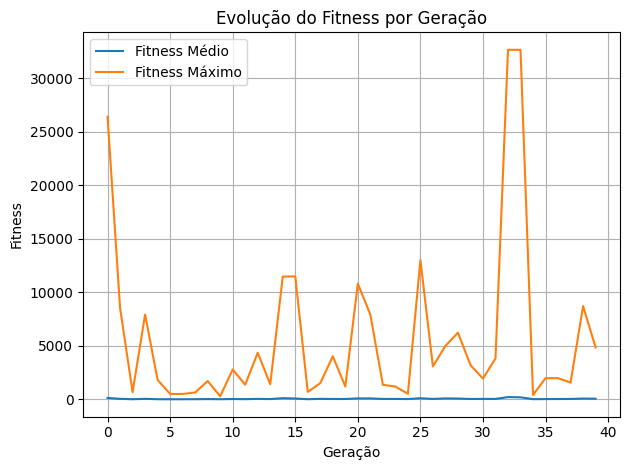

Melhor gamma: 1.7056
Melhor k: 1.0485
Melhor h: 3.1622

Max(v) = 1.1000 m/s
Max(omega) = 176.7299°/s


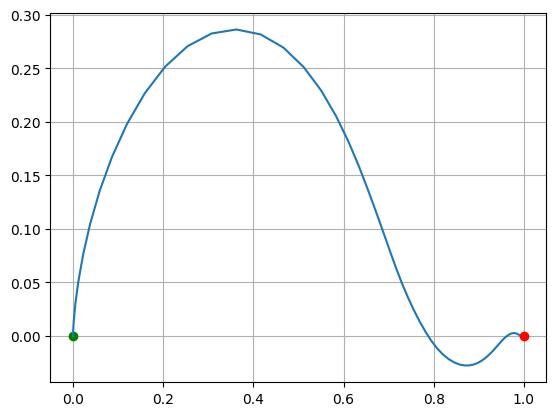

In [38]:
x0 = [0, 0, np.pi/2]  # Reset initial state for Karim's model
goalPos = [1, 0]  # Reset goal position for Karim's model

v_ref = 1.1
w_ref = 300 * np.pi / 180  # Convert to rad/s

def fitness_function_a(pop):
    global gamma, k, h

    fitness_values = []

    for ind in pop:
        gamma  = bin_to_real(ind[:int(1/3*len(ind))], 0, 4)
        k      = bin_to_real(ind[int(1/3*len(ind)):int(2/3*len(ind))], 0, 4)
        h      = bin_to_real(ind[int(2/3*len(ind)):], 0, 4)

        sol_a = solve_ivp(cinematicModel_Aicardi, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
        x_a, y_a, phi_a, e_a, alpha_a, v_a, w_a = calculoVariaveis_Aicardi(sol_a.y)

        F = 1/(np.abs(np.max(v_a) - v_ref)) + 1/(np.abs(np.max(np.abs(w_a)) - w_ref))

        fitness_values.append(F)

    return fitness_values

best = evolve(
    fitnessFunction=fitness_function_a,
    length=60,
    popSize=200,
    maxGens=40,
    probMutation=0.03,
    probCrossover=1
)

gamma_best   = bin_to_real(best[:int(1/3*len(best))], 0, 4)
k_best       = bin_to_real(best[int(1/3*len(best)):int(2/3*len(best))], 0, 4)
h_best       = bin_to_real(best[int(2/3*len(best)):], 0, 4)

print(f"Melhor gamma: {gamma_best:.4f}")
print(f"Melhor k: {k_best:.4f}")
print(f"Melhor h: {h_best:.4f}")

gamma = gamma_best
k = k_best 
h = h_best

sol_a = solve_ivp(cinematicModel_Aicardi, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
x_a, y_a, phi_a, e_a, alpha_a, v_a, omega_a = calculoVariaveis_Aicardi(sol_a.y)

print()
print(f'Max(v) = {np.max(v_a):.4f} m/s')
print(f'Max(omega) = {np.max(np.abs(omega_a*180/np.pi)):.4f}°/s')

plt.plot(goalPos[0], goalPos[1], 'ro')  # Plot goal position
plt.plot(x_a[0], y_a[0], 'go')  # Plot goal position
plt.plot(x_a, y_a) 
plt.grid()

### fmincon

C:\Users\Matheus Lucas\AppData\Local\Temp\ipykernel_9368\2482257525.py:22: OptimizeWarning: Unknown solver options: tol
  result = minimize(cost_function_a, controlVar_guess_a, method='SLSQP', bounds=bounds, options={'maxiter': 1000, 'tol':1e-6, 'disp': True})


Inequality constraints incompatible    (Exit mode 4)
            Current function value: -101477.09499906024
            Iterations: 11
            Function evaluations: 81
            Gradient evaluations: 10
Melhor gamma: 3.9045
Melhor k: 2.2555
Melhor h: 1.5113

Max(v) = 2.3297 m/s
Max(w) = 300.0006 °/s


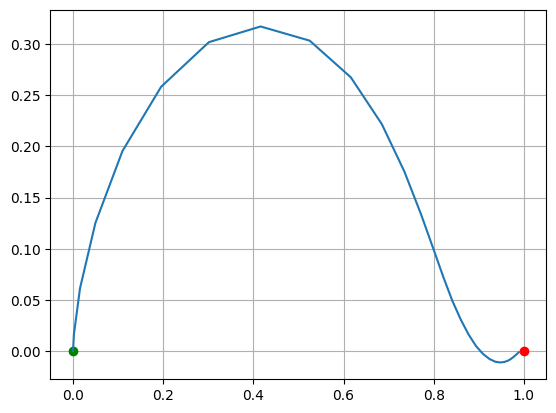

In [53]:
x0 = [0, 0, np.pi/2]  # Reset initial state 
goalPos = [1, 0]  # Reset goal position

v_ref = 1.1
w_ref = 300*np.pi/180

def cost_function_a(params):
    global gamma, k, h

    gamma, k, h = params

    sol_a = solve_ivp(cinematicModel_Aicardi, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
    x_a, y_a, phi_a, e_a, alpha_a, v_a, w_a = calculoVariaveis_Aicardi(sol_a.y)

    F =  1/np.abs(np.max(v_a) - v_ref) +1/np.abs(np.max(np.abs(w_a)) - w_ref)
    
    return -F

controlVar_guess_a = [0.1, 1, 1]  # Initial guess for gamma, k, h
bounds = [(0, 4), (0, 4), (0, 4)]  # Bounds for gamma, k, h

result = minimize(cost_function_a, controlVar_guess_a, method='SLSQP', bounds=bounds, options={'maxiter': 1000, 'tol':1e-6, 'disp': True})

gamma_best, k_best, h_best = result.x

print(f"Melhor gamma: {gamma_best:.4f}")
print(f"Melhor k: {k_best:.4f}")
print(f"Melhor h: {h_best:.4f}")

global gamma, k, h
gamma, k, h = gamma_best, k_best, h_best

sol_a = solve_ivp(cinematicModel_Aicardi, t_span, x0, t_eval=t_eval, method='RK45', events=stopEvent)
x_a, y_a, phi_a, e_a, alpha_a, v_a, w_a = calculoVariaveis_Aicardi(sol_a.y)

print()
print(f'Max(v) = {np.max(v_a):.4f} m/s')
print(f'Max(w) = {np.max(np.abs(w_a*180/np.pi)):.4f} °/s')

plt.plot(goalPos[0], goalPos[1], 'ro')  # Plot goal position
plt.plot(x_a[0], y_a[0], 'go')  # Plot goal
plt.plot(x_a, y_a)
plt.grid()